In [1]:
import gym
import torch
from torch import nn
import numpy as np
from collections import deque, namedtuple
import random
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import time

In [2]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
                    nn.Linear(state_dim, 32),
                    nn.Sigmoid(),
                    nn.Linear(32,8),
                    nn.Sigmoid(),
                    nn.Linear(8,action_dim),
                    )
    def forward(self, x):
        return self.net(x)

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
                    nn.Linear(state_dim + action_dim, 32),
                    nn.Sigmoid(),
                    nn.Linear(32,8),
                    nn.Sigmoid(),
                    nn.Linear(8,1)
                    )
    def forward(self, s, a):        
        return self.net(torch.cat((s,a), dim = 1))

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state'))

class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity 
        self.memory = deque(maxlen = self.capacity)
    
    def update(self, *args):
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
def t(x): return torch.from_numpy(x).float()

def soft_update(local_model, target_model, tau):
    """Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target

    Params
    ======
        local_model: PyTorch model (weights will be copied from)
        target_model: PyTorch model (weights will be copied to)
        tau (float): interpolation parameter 
    """
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [4]:
class DDPGAgent:
    def __init__(self, env, mem_capacity, n):
        self.env = env
        self.n_episodes = n
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = 1
        
        self.actor = Actor(self.state_dim, self.action_dim)
        self.actor_target = Actor(self.state_dim, self.action_dim)
        
        self.critic = Critic(self.state_dim, self.action_dim)
        self.critic_target = Critic(self.state_dim, self.action_dim)
        
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters())
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters())
        
        self.memory = ReplayMemory(mem_capacity)
        self.rewards = []
        self.losses = []
        
             
    def train(self):
        
        self.fill_memory()
        step = 0
        
        pbar = tqdm(total=self.n_episodes, position=0, leave=True)
        for episode in range(self.n_episodes):
            state = self.env.reset()
            is_done = False
            total_rewards = 0
              
            while not is_done:
                action = self.actor(t(state)).detach().float()
                
                
                next_state, reward, is_done, _ = self.env.step(action)
                
                total_rewards += reward
                        
                self.memory.update(torch.from_numpy(state), 
                               torch.tensor(action),  
                               torch.tensor([reward]).float(), 
                               torch.from_numpy(next_state))
                
                batch = self.memory.sample(32)
                
                loss = self.update_models(batch)
                self.update_target_models()                   
                self.losses.append(loss)    
                step += 1
                
            self.rewards.append(total_rewards)
            pbar.update()
                
        
    def update_models(self, n_batch):
        gamma = 0.99
        
        batch = Transition(*zip(*n_batch))
               
        rewards = torch.cat(batch.reward).float()
        next_states = torch.stack(batch.next_state).float()
        states = torch.stack(batch.state).float()
        actions = torch.cat(batch.action).float().unsqueeze(1)
        
        
        additional_qs = self.critic_target(next_states, self.actor_target(next_states))
        
        y = rewards.unsqueeze(1) + additional_qs * gamma
        
        q = self.critic(states, actions)

        # Update critic
        loss_critic = F.smooth_l1_loss(q, y)
        self.critic_optimizer.zero_grad()
        loss_critic.backward()
        for param in self.critic.parameters():
            param.grad.data.clamp_(-1, 1)
        self.critic_optimizer.step()
        
        # Update agent
        loss_actor = -self.critic(states, self.actor(states)).mean()
        self.actor_optimizer.zero_grad()
        loss_actor.backward()
        for param in self.actor.parameters():
            param.grad.data.clamp_(-1, 1)
        self.actor_optimizer.step()
        
        return (loss_critic.item(), loss_actor.item())
        
    def update_target_models(self):
        soft_update(self.actor, self.actor_target, 0.99)
        soft_update(self.critic, self.critic_target, 0.99)
                
    def fill_memory(self, size = 32):
        state = self.env.reset()
        for _ in range(size):
            action = self.actor(t(state)).detach().float()
            next_state, reward, is_done, _ = self.env.step(action)
            self.memory.update(torch.from_numpy(state), 
                               torch.tensor([action]), 
                               torch.tensor([reward]), 
                               torch.from_numpy(next_state))
            state = next_state
        
    def test(self):
        state = self.env.reset()
        is_done = False
        while not is_done:
            action = self.actor(t(state)).detach().numpy()
            next_state, reward, is_done, _ = self.env.step(action)
            state = next_state
            env.render()
            time.sleep(0.01)

In [ ]:
MEM_CAPACITY = 10_000
MAX_EPISODES = 1000

env = gym.make("Pendulum-v0")

agent = DDPGAgent(env, MEM_CAPACITY, MAX_EPISODES)
agent.train()

 11%|█         | 108/1000 [01:11<10:57,  1.36it/s]

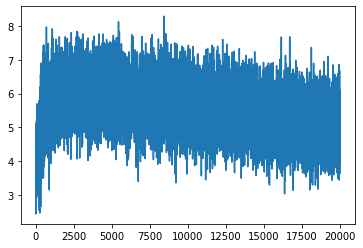

In [138]:
l= np.array(agent.losses)
plt.plot(l[:,0])

100%|██████████| 100/100 [01:24<00:00,  1.19it/s]


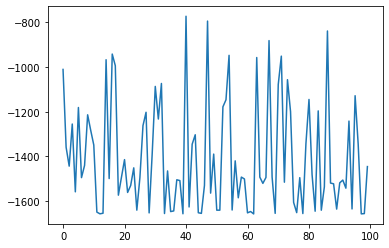

In [136]:
from matplotlib import pyplot as plt
plt.plot(agent.rewards)
#plt.plot(agent.losses)po 

In [137]:
agent.test()
agent.env.close()

In [346]:
batch = agent.memory.sample(32)
n_batch = Transition(*zip(*batch))

In [503]:
agent.env.observation_space

Box(-8.0, 8.0, (3,), float32)

In [142]:
[ns for ns in n_batch.next_state if ns is not None]

[tensor([ 0.9928,  0.1201, -1.5777], dtype=torch.float64),
 tensor([-0.8099, -0.5866, -6.0983], dtype=torch.float64),
 tensor([ 0.6755,  0.7373, -3.7109], dtype=torch.float64),
 tensor([ 0.1149,  0.9934, -5.1681], dtype=torch.float64),
 tensor([ 0.9967, -0.0812, -1.4364], dtype=torch.float64),
 tensor([ 0.8637,  0.5040, -2.9226], dtype=torch.float64),
 tensor([ 0.4595, -0.8882, -2.3637], dtype=torch.float64),
 tensor([-0.5964, -0.8027, -5.7930], dtype=torch.float64),
 tensor([ 0.9587,  0.2845, -2.1266], dtype=torch.float64),
 tensor([ 0.5610, -0.8278, -1.9143], dtype=torch.float64),
 tensor([ 0.9890, -0.1477, -1.3394], dtype=torch.float64),
 tensor([-0.0867, -0.9962, -4.6756], dtype=torch.float64),
 tensor([-0.4287,  0.9034, -6.4402], dtype=torch.float64),
 tensor([ 0.7811,  0.6244, -3.0944], dtype=torch.float64),
 tensor([-0.3423, -0.9396, -5.2512], dtype=torch.float64),
 tensor([ 0.3251, -0.9457, -2.9262], dtype=torch.float64),
 tensor([ 0.9983,  0.0579, -1.2500], dtype=torch.float64

In [169]:

agent.model(torch.stack(batch.state).float())

AttributeError: 'list' object has no attribute 'state'

In [186]:
t = torch.tensor([[1,2,3],[4,5,6]])
torch.gather(t, 1, torch.tensor([[1],[1]]))

tensor([[2],
        [5]])

In [175]:
t

tensor([[1, 2],
        [3, 4]])